`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022
 Выпонила: Рудская Ирина
 Вариант №17`

In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.  

В практических примерах ниже показано:   

* как вырастить дерево и сделать обрезку его ветвей     
* как вырастить случайный лес    
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: дерево классификации, случайный лес, дерево регрессии 

*Данные*: `default_of_credit_card_clients` 

*Источник*: https://github.com/aksyuk/MTML/blob/main/Labs/data/default_of_credit_card_clients.csv

# Указания к выполнению


## Загружаем пакеты

In [2]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [3]:
# константы
#  ядро для генератора случайных чисел
my_seed = 17
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [4]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Данные по кредитам 30000 клиентов банков Тайваня (статистика 2005 года). Задача: спрогнозировать дефолт платежа в следущем месяце по статистике за 6 предыдущих месяцев и по общим сведениям о клиенте. Источник данных: статья Yeh, I. C., & Lien, C. H. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. Набор данных был загружен из репозитория UCI (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) 12.10.2021.

* `LIMIT_BAL` – размер выданного кредита (новых тайваньских долларов);
* `SEX` – пол: 1 = мужской, 2 = женский;
* `EDUCATION` – образование: 1 = аспирантура, 2 = университет, 3 = старшая школа, 4 = другое;
* `MARRIAGE` – семейное положение: 1 = женат/замужем, 2 = одинок, 3 = другое;
* `AGE` – возраст, лет;
* `PAY_0`, `PAY_2`, ..., `PAY_6` – статус последних ежемесячных платежей, с сентября (`PAY_0`) по апрель (`PAY_6`) 2005 года: -1 = платёж внесён вовремя, 1 = платёж внесён с опозданием на 1 месяц; 2 = с опозданием на 2 месяца, и т.д., 9 = с опозданием на 9 месяцев и более;
* `BILL_AMT1`, ..., `BILL_AMT6` – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (`BILL_AMT1`) по апрель (`BILL_AMT6`) 2005 года;
* `PAY_AMT1`, ..., `PAY_AMT6` – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (`PAY_AMT1` за август) по апрель (`PAY_AMT6` за март) 2005 года;
* `Y` – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).

Зависимая переменная: `Y`

Объясняющие переменные все, кроме: 
`Y`,`PAY_4`, `PAY_5`, `PAY_6`, `BILL_AMT4`, `BILL_AMT5`, `BILL_AMT6`, `PAY_AMT1`, ..., `PAY_AMT6`


Загружаем данные во фрейм и выясняем их размерность.  

In [5]:
# загружаем таблицу и превращаем её во фрейм
DF_all = pd.read_csv('https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv')

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [6]:
# выбираем нужные значения
DF_raw = DF_all.drop(["PAY_4", "PAY_5", "PAY_6", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
                      "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",], axis = 1)

In [7]:
# типы столбцов
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
Y            int64
dtype: object

Следует обратить внимание на категориальные переменные `SEX`, `EDUCATION`, `MARRIAGE`, которые могут принимать несколько значений.

In [8]:
# первые 7 строк столбцов
DF_raw.head(7)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,Y
0,20000,2,2,1,24,2,2,-1,3913,3102,689,1
1,120000,2,2,2,26,-1,2,0,2682,1725,2682,1
2,90000,2,2,2,34,0,0,0,29239,14027,13559,0
3,50000,2,2,1,37,0,0,0,46990,48233,49291,0
4,50000,1,2,1,57,-1,0,-1,8617,5670,35835,0
5,50000,1,1,2,37,0,0,0,64400,57069,57608,0
6,500000,1,1,2,29,0,0,0,367965,412023,445007,0


Отложим 15% наблюдений для прогноза.  

In [9]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()` бесполезен для категориальных столбцов, поэтому рассчитаем частоты категорий по каждому столбцу. Для вывода отчёта воспользуемся форматированием на Markdown.   

Перед подсчетом статистик обратим внимание:

* в столбце `EDUCATION` есть значения `0`, `5`, `6`, которые будем считать как пропуски 
* в столбце `MARRIAGE` есть значение `0`, которое тоже будем считать как пропуск  

Поэтому заменим эти значения на пропуски для более удобной обработки результатов.

In [10]:
# для обучащей выборки
df_DF = pd.DataFrame(DF)
df_DF['EDUCATION'] = df_DF['EDUCATION'].replace(0, np.nan)
df_DF['EDUCATION'] = df_DF['EDUCATION'].replace(5, np.nan)
df_DF['EDUCATION'] = df_DF['EDUCATION'].replace(6, np.nan)
df_DF['MARRIAGE'] = df_DF['MARRIAGE'].replace(0, np.nan)
DF = df_DF

In [11]:
# для тестовой выборки
df_DF_predict = pd.DataFrame(DF_predict)
df_DF_predict['EDUCATION'] = df_DF_predict['EDUCATION'].replace(0, np.nan)
df_DF_predict['EDUCATION'] = df_DF_predict['EDUCATION'].replace(5, np.nan)
df_DF_predict['EDUCATION'] = df_DF_predict['EDUCATION'].replace(6, np.nan)
df_DF_predict['MARRIAGE'] = df_DF_predict['MARRIAGE'].replace(0, np.nan)
DF_predict = df_DF_predict

In [12]:
# считаем частоты по столбцам, учитывая пропуски

for col in DF.columns[DF.columns == 'SEX'] :
    freq_col = DF[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + 
            '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))

for col in DF.columns[DF.columns == 'EDUCATION'] :
    freq_col = DF[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + 
            '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))
    
for col in DF.columns[DF.columns == 'MARRIAGE'] :
    freq_col = DF[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + 
            '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))
    
    # для сохранения в pdf
    # print('\n', col, '\n', 
    #       '\n'.join(list(map(concat_func, str_names, str_freqs))))

**SEX**</br>`2`:&ensp;&ensp;&ensp;&ensp;0.603</br>`1`:&ensp;&ensp;&ensp;&ensp;0.397

**EDUCATION**</br>`2.0`:&ensp;&ensp;&ensp;&ensp;0.466</br>`1.0`:&ensp;&ensp;&ensp;&ensp;0.354</br>`3.0`:&ensp;&ensp;&ensp;&ensp;0.164</br>`nan`:&ensp;&ensp;&ensp;&ensp;0.012</br>`4.0`:&ensp;&ensp;&ensp;&ensp;0.004

**MARRIAGE**</br>`2.0`:&ensp;&ensp;&ensp;&ensp;0.532</br>`1.0`:&ensp;&ensp;&ensp;&ensp;0.455</br>`3.0`:&ensp;&ensp;&ensp;&ensp;0.01</br>`nan`:&ensp;&ensp;&ensp;&ensp;0.002

Так как категориальных переменных всего 3, то пропуски легко заметить в этом результате подсчета частот.
Если брать наблюдения `EDUCATION` и `MARRIAGE` отдельно друг от друга, то пропуски в них состовляют, очевидно, не более 2% и 1% соответственно. 

Для проверки выведем их отдельно.

In [13]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF.isna().sum()
nas = np.around(nas / DF.shape[0], 3)
nas[nas > 0]

EDUCATION    0.012
MARRIAGE     0.002
dtype: float64

Подсчитаем, сколько наблюдений мы потеряем, если выбросим все строки хотя бы с одним пропуском.  

In [14]:
na_rows = sum([True for idx, row in DF.iterrows() if any(row.isnull())])
print('Из-за пропусков пропадает ', na_rows, ' строк (',
      np.around(na_rows / DF.shape[0] * 100, 1), '%)', sep='')

Из-за пропусков пропадает 342 строк (1.3%)


Выводы по описательным статистикам: доли классов (`Y`) сопоставимы, наибольшее количество категорий у объясняющей переменной `EDUCATION`. Строки с пропусками составляют не более 2%, поэтому мы уберём их из обучающей выборки.  

In [15]:
# выкидываем пропуски из обучащей
DF = DF.dropna()
DF.shape

(25158, 12)

In [16]:
# выкидываем пропуски из отложенных наблюдений
DF_predict = DF_predict.dropna()
DF_predict.shape

(4443, 12)

## Распределение предикторов внутри классов  по зависимой переменной

Для начала рассмотрим переменные, которые являются категориальными (`EDUCATION`, `MARRIAGE` и `SEX`). Оценивать их связь с зависимой переменной с помощью корреляционной матрицы некорректно. Вместо этого можно воспользоваться [критерием согласия Хи-квадрат](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0), который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.     
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы).  

In [17]:
for col in DF.columns[1:4] :
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

Результатом проверки стало, что ни одна из категориальных объясняющих переменных не приняла нулевую гипотезу, значит, распределение долей в таблице сопряжённости неслучайно (т.е. два показателя зависимы друг от друга).

Построим корреляционную матрицу для непрерывных переменных. 

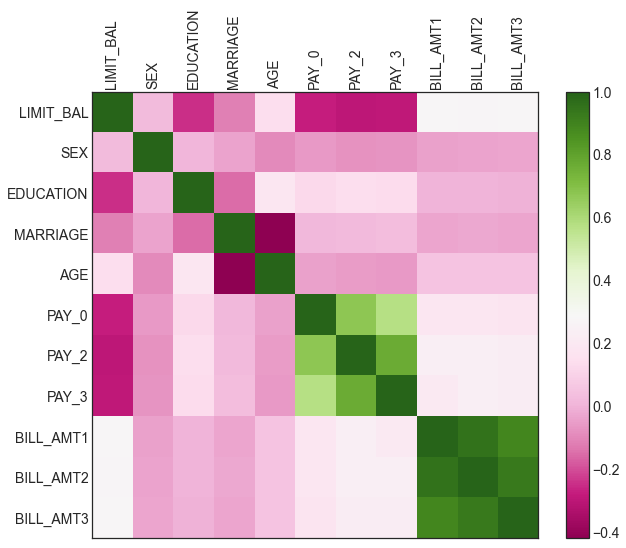

In [18]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr() 
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими непрерывными переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Напоминание: для переменных `EDUCATION`, `MARRIAGE` и `SEX` она не информативна.

### Создадим фиктивные переменные

In [19]:
# для обучающей выборки
DF_copy = DF.copy()
categorical_cols = ['SEX','EDUCATION','MARRIAGE']
DF_copy = pd.get_dummies(DF_copy, columns = categorical_cols)

In [20]:
DF_copy.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,Y,SEX_1,SEX_2,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0,MARRIAGE_1.0,MARRIAGE_2.0,MARRIAGE_3.0
15854,130000,27,0,0,0,76885,79106,81231,0,0,1,0,1,0,0,1,0,0
7388,150000,41,0,0,0,64425,57073,32516,0,1,0,0,0,1,0,0,1,0
1799,130000,28,0,0,0,132258,133781,133834,0,1,0,0,0,1,0,0,1,0
735,70000,50,-2,-2,-1,27345,-1041,17571,0,0,1,0,0,1,0,1,0,0
22485,20000,43,0,0,0,11511,12521,13851,0,0,1,0,1,0,0,1,0,0


In [21]:
# для проверки
DF_copy.shape

(25158, 18)

In [22]:
# для тестовой выборки
DF_predict_copy = DF_predict.copy()
categorical_cols = ['SEX','EDUCATION','MARRIAGE']
DF_predict_copy = pd.get_dummies(DF_predict_copy, columns = categorical_cols)

In [23]:
DF_predict_copy.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,Y,SEX_1,SEX_2,EDUCATION_1.0,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0,MARRIAGE_1.0,MARRIAGE_2.0,MARRIAGE_3.0
2,90000,34,0,0,0,29239,14027,13559,0,0,1,0,1,0,0,0,1,0
4,50000,57,-1,0,-1,8617,5670,35835,0,1,0,0,1,0,0,1,0,0
15,50000,23,1,2,0,50614,29173,28116,0,0,1,0,0,1,0,0,0,1
21,120000,39,-1,-1,-1,316,316,316,1,0,1,0,1,0,0,1,0,0
30,230000,27,-1,-1,-1,16646,17265,13266,0,0,1,1,0,0,0,0,1,0


In [24]:
# для проверки
DF_predict_copy.shape

(4443, 18)

# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [25]:
# выращиваем дерево на всех объясняющих
X = DF_copy.drop(['Y'], axis=1)
y = DF_copy['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

4658

In [26]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

53

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [27]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.728


## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [28]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1751
Энтропия листьев для первых 5 значений alpha: [0.00207746 0.00211643 0.00213591 0.00218541 0.00221144]


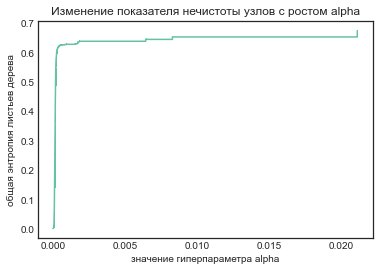

In [29]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [30]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 370.03 секунд


In [31]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 21.02 секунд


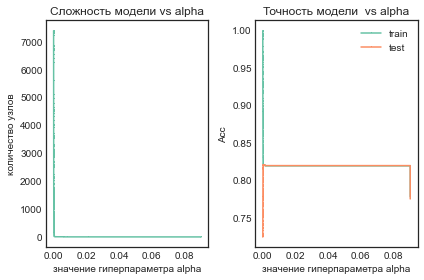

In [32]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [33]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 31 
соответствующая Acc на тестовой: 0.82 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.74


$Acc$  на тестовой лучше, чем до этого.

Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [34]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

2474

Количество листьев стало почти в два раза меньше (предыдущее значение - `4658`).

In [35]:
# глубина дерева: количество узлов от корня до листа
# в самой длинной ветви
clfs[opt_nodes_num].get_depth()

41

Глубина дерева так же уменьшилась (предыдущее значение - `53`).

#### Вывод

Таким образом, построена модель дерева с обрезкой ветвей и оптимизирован её параметр с помощью перекрёстной проверки.

* Оптимальное значение параметра - `2474`. 

Размер дерева не позволяет представить его в графическом виде полностью.

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации, поэтому для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [36]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19, 17, 17, 13, 13, 13, 13, 13, 13, 13, 13, 13, 9, 9, 9, 9, 5, 5, 3, 1]

In [37]:
plot_tree?

Количество узлов: 19 
Точность дерева на тестовой: 0.819


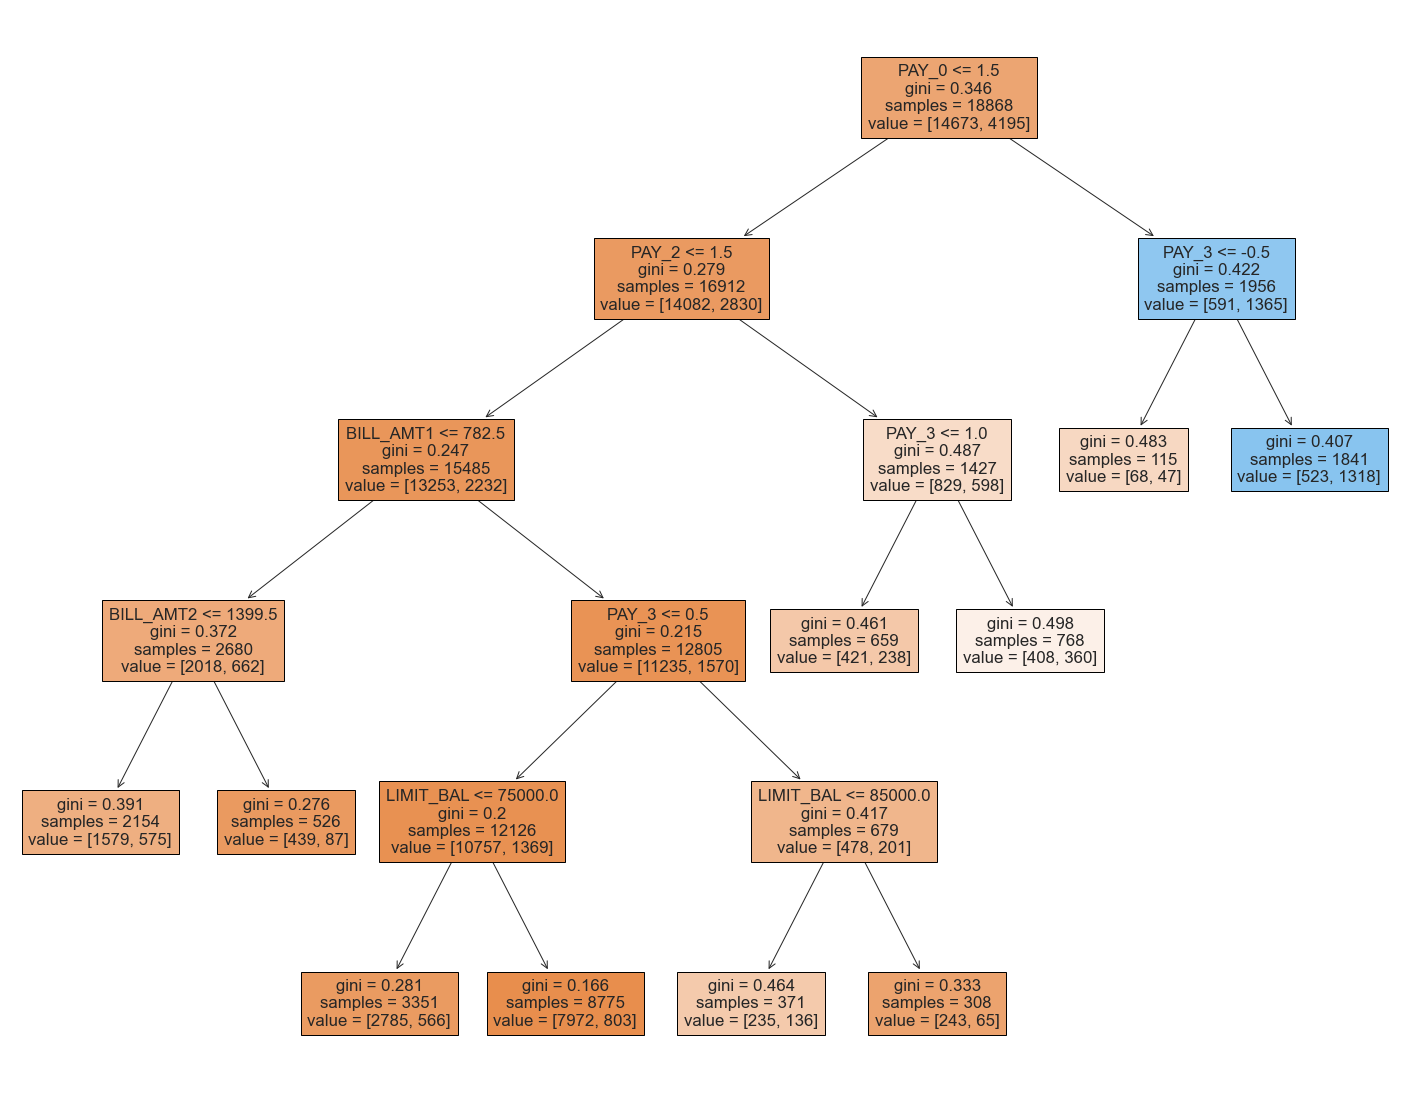

In [38]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 19
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [39]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- PAY_0 <= 1.50
|   |--- PAY_2 <= 1.50
|   |   |--- BILL_AMT1 <= 782.50
|   |   |   |--- BILL_AMT2 <= 1399.50
|   |   |   |   |--- class: 0
|   |   |   |--- BILL_AMT2 >  1399.50
|   |   |   |   |--- class: 0
|   |   |--- BILL_AMT1 >  782.50
|   |   |   |--- PAY_3 <= 0.50
|   |   |   |   |--- LIMIT_BAL <= 75000.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- LIMIT_BAL >  75000.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- PAY_3 >  0.50
|   |   |   |   |--- LIMIT_BAL <= 85000.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- LIMIT_BAL >  85000.00
|   |   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.50
|   |   |--- PAY_3 <= 1.00
|   |   |   |--- class: 0
|   |   |--- PAY_3 >  1.00
|   |   |   |--- class: 0
|--- PAY_0 >  1.50
|   |--- PAY_3 <= -0.50
|   |   |--- class: 0
|   |--- PAY_3 >  -0.50
|   |   |--- class: 1



# Случайный лес  



У модели случайного леса два настроечных параметра: количество деревьев $B$ и количество признаков для построения отдельного дерева $m$. Настроим сеточный поиск для их подбора.  

In [40]:
# сколько столбцов в обучающих данных (p)
X_m = X.shape[1]
# возьмём значения для m: p, p/2, sqrt(p) и log2(p)
ms = np.around([X_m, X_m / 2, np.sqrt(X_m), np.log2(X_m)]).astype(int)
ms

array([17,  8,  4,  4])

In [41]:
# настроим параметры случайного леса с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70],
              'max_features' : ms}

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# таймер
tic = time.perf_counter()
clf = GridSearchCV(RandomForestClassifier(DecisionTreeClassifier()),
                   param_grid, scoring='accuracy', cv=kfold)
random_forest = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 347.05 секунд


In [42]:
# точность лучшей модели
np.around(random_forest.best_score_, 3)

0.81

In [43]:
# количество деревьев у лучшей модели
random_forest.best_estimator_.get_params()['n_estimators']

60

In [44]:
# количество объясняющих у лучшей модели
random_forest.best_estimator_.get_params()['max_features']

4

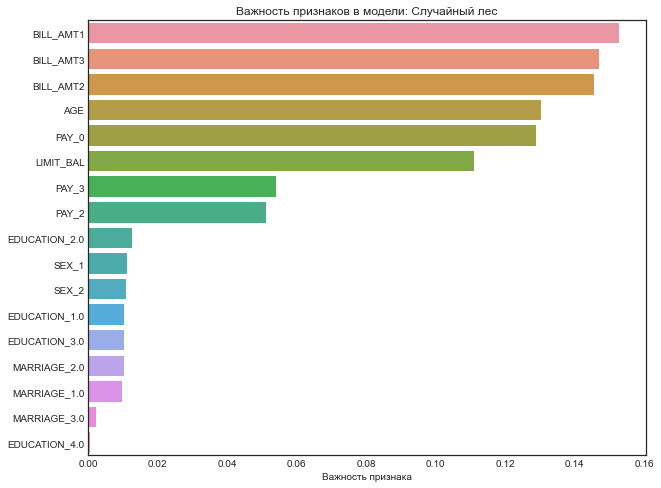

In [45]:
# рисуем график относительной важности каждого признака
plot_feature_importance(random_forest.best_estimator_.feature_importances_,
                        X.columns, 'Случайный лес')

In [46]:
# записываем точность
score.append(np.around(random_forest.best_score_, 3))
score_models.append('random_forest_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой 
для модели random_forest_GS : 0.81


#### Вывод

Оптимальные значения параметров для модели, построенной методом `Случайный лес`:

* количество деревьев у лучшей модели - `60`
* количество объясняющих у лучшей модели - `4`

Точность модели `0.81`.


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [47]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.728
1,pruned_tree,0.740
2,random_forest_GS,0.810


#### Вывод

Все модели показывают среднюю точность по показателю $Acc$, однако самой точной оказывается модель случайного леса.

Сделаем прогноз на отложенные наблюдения.   

In [49]:
# данные для прогноза
X_pred = DF_predict_copy.drop(['Y'], axis=1)
# строим прогноз
y_hat = random_forest.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_copy['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3451
           1       0.63      0.39      0.48       992

    accuracy                           0.81      4443
   macro avg       0.74      0.66      0.68      4443
weighted avg       0.80      0.81      0.80      4443



#### Вывод

Для выбранной модели:

* Специфичность - `0.94`
* Чувствительность - `0.39`
* Совокупная точность - `0.81`


В целом это говорит о хорошем качестве модели, хотя чувствительность показывает не самый лучший результат. 

#### Вывод

Сравним полученную совокупную точность на отложенных наблюдениях с точностью, полученной для модели, построенной на обучающей выборке с перекресной проверкой:

* `0.81` `=` `0.81`

Следует отметить, что в данных были категориальные переменные, что ухудшает работу по созданию наиболее точной модели.

# Источники 

1. Джеймс Г., Уиттон Д., Хасти Т., Тибширани Р. Введение в статистическое обучение с примерами на языке R. Пер. с англ. С.Э. Мастицкого – М.: ДМК Пресс, 2016 – 450 с.  
1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. *Tong Wang*, *Cynthia Rudin*, *Finale Doshi-Velez*, *Yimin Liu*, *Erica Klampfl*, *Perry MacNeille* A Bayesian Framework for Learning Rule Sets for Interpretable Classification / Journal of Machine Learning Research 18 (2017) 1-37. URL: <https://jmlr.org/papers/volume18/16-003/16-003.pdf>  
1. *George Pipis* How to Run the Chi-Square Test in Python / medium.com. URL: <https://medium.com/swlh/how-to-run-chi-square-test-in-python-4e9f5d10249d>   
1. *Bernd Klein* What are Decision Trees? / python-course.eu. URL: <https://www.python-course.eu/Decision_Trees.php>  
1. Pruning decision trees - tutorial / kaggle.com. URL: <https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial>  
1. Post pruning decision trees with cost complexity pruning / scikit-learn.org. URL: <https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html>  
1. *Piotr Płoński* Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python / mljar.com. URL: <https://mljar.com/blog/visualize-decision-tree/>  
1. Random Forest Feature Importance Plot / www.analyseup.com. URL: <https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html>  